# Demo of our Timeseries Database Implementation

Vantage Point tress improve the performance of similarity search by an order of magnitude

Before : 1 loop, best of 3: 1.18 s per loop

After :  1 loop, best of 3: 514 ms per loop

In [ ]:
%matplotlib inline
from webutils import WebClient
import matplotlib.pyplot as plt
import json

### Create some data

###### IGNORE THIS CELL IF JUST WANT TO SEE THE SYNTAX FOR HOW TO USE THE DB

In [27]:
# This is utility function to make sample time series

import timeseries as ts
import numpy as np
from scipy.stats import norm

# m is the mean, s is the standard deviation, and j is the jitter
# the meta just fills in values for order and blarg from the schema
# ts_len is the length of each timeseries. It has to be the same
def tsmaker(m, s, j, ts_len = 1024):
    "returns metadata and a time series in the shape of a jittered normal"
    meta={}
    meta['order'] = int(np.random.choice([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]))
    meta['blarg'] = int(np.random.choice([1, 2]))
    t = np.arange(0.0, 1.0, 1/ts_len)
    v = norm.pdf(t, m, s) + j*np.random.randn(ts_len)
    return meta, ts.TimeSeries(t, v)


N_ts = 1000 # number of timeseries
N_vp = 10 # this is the number of vantage points we're going to set up in the database.


# choose N_vp distinct vantage point time series
vpkeys = ["ts-{}".format(i) for i in np.random.choice(range(N_ts), size=N_vp, replace=False)]


#Set up N_ts time series
mus = np.random.uniform(low=0.0, high=1.0, size=N_ts)
sigs = np.random.uniform(low=0.05, high=0.4, size=N_ts)
jits = np.random.uniform(low=0.05, high=0.2, size=N_ts)


# dictionaries for time series and their metadata
tsdict={}
metadict={}
for i, m, s, j in zip(range(N_ts), mus, sigs, jits):
    meta, tsrs = tsmaker(m, s, j)
    # the primary key format is ts-1, ts-2, etc
    pk = "ts-{}".format(i)
    tsdict[pk] = tsrs
    meta['vp'] = False # augment metadata with a boolean asking if this is a  VP.
    metadict[pk] = meta
    


### Start the `Server` and the `Webserver`

```bash
python go_server.py -len $TS_LEN -vps $NUMVPS &

python go_webserver.py &
```

### Set up a `WebClient` instance to talk to the `WebServer`

In [28]:
# Create a webclient instance with the correct url.
# w = WebClient('http://localhost:8080')
w = WebClient('http://www.adjch.me:8080')


### Adding Simple Triggers

In [ ]:
# this is how you add triggers
r = w.add_trigger('junk', 'insert_ts', None, 'db:one:ts')
assert r.status_code == 200

r = w.add_trigger('stats', 'insert_ts', ['mean', 'std'], None)
assert r.status_code == 200


### Adding More Complicated Triggers

##### One for each vantage point to compute the distance

In [30]:
# add triggers for each vantage point to automatically compute distance
for i in range(N_vp):
    w.add_trigger('corr', 'insert_ts', ["d_vp-{}".format(i)], tsdict[vpkeys[i]])
    
    # change the metadata for the vantage points to have meta['vp']=True
    metadict[vpkeys[i]]['vp']=True
    metadict[vpkeys[i]]['vp_num']=i

### Inserting TimeSeries to the database and Upserting their metadata

In [31]:
# this is ho
for i,k in enumerate(tsdict):
    w.insert_ts(k, tsdict[k])
    w.upsert_meta(k, metadict[k])
    if i % 100 == 0: 
        print("Done with {} inserts".format(i))

print("UPSERTS FINISHED")

Done with 0 inserts
Done with 100 inserts
Done with 200 inserts
Done with 300 inserts
Done with 400 inserts
Done with 500 inserts
Done with 600 inserts
Done with 700 inserts
Done with 800 inserts
Done with 900 inserts
UPSERTS FINISHED


### Selects

###### 1. Most Basic

In [32]:
print(w.select(additional={'limit':100}).content)

b'{"ts-27": {}, "ts-239": {}, "ts-300": {}, "ts-271": {}, "ts-422": {}, "ts-492": {}, "ts-570": {}, "ts-402": {}, "ts-345": {}, "ts-720": {}, "ts-554": {}, "ts-411": {}, "ts-632": {}, "ts-897": {}, "ts-517": {}, "ts-319": {}, "ts-627": {}, "ts-420": {}, "ts-230": {}, "ts-671": {}, "ts-381": {}, "ts-719": {}, "ts-936": {}, "ts-307": {}, "ts-614": {}, "ts-90": {}, "ts-989": {}, "ts-511": {}, "ts-596": {}, "ts-128": {}, "ts-664": {}, "ts-37": {}, "ts-909": {}, "ts-123": {}, "ts-540": {}, "ts-202": {}, "ts-282": {}, "ts-396": {}, "ts-284": {}, "ts-191": {}, "ts-840": {}, "ts-227": {}, "ts-224": {}, "ts-987": {}, "ts-562": {}, "ts-455": {}, "ts-534": {}, "ts-309": {}, "ts-380": {}, "ts-959": {}, "ts-737": {}, "ts-555": {}, "ts-957": {}, "ts-434": {}, "ts-454": {}, "ts-541": {}, "ts-51": {}, "ts-751": {}, "ts-416": {}, "ts-793": {}, "ts-809": {}, "ts-707": {}, "ts-918": {}, "ts-802": {}, "ts-283": {}, "ts-547": {}, "ts-626": {}, "ts-873": {}, "ts-908": {}, "ts-900": {}, "ts-255": {}, "ts-708

##### 2. Select with specific column criteria

In [33]:
print(w.select({'order':1},additional={'limit':10}).content)


b'{"ts-819": {}, "ts-886": {}, "ts-447": {}, "ts-398": {}, "ts-918": {}, "ts-697": {}, "ts-422": {}, "ts-166": {}, "ts-591": {}, "ts-944": {}}'


##### 3. Range queries and requesting spefic columns back

In [34]:
print(w.select({'order':{'>=':1}},['pk','order'], additional={'limit':10}).content)

b'{"ts-239": {"order": 4, "pk": "ts-239"}, "ts-492": {"order": 5, "pk": "ts-492"}, "ts-570": {"order": 4, "pk": "ts-570"}, "ts-422": {"order": 1, "pk": "ts-422"}, "ts-402": {"order": 4, "pk": "ts-402"}, "ts-554": {"order": 1, "pk": "ts-554"}, "ts-411": {"order": 1, "pk": "ts-411"}, "ts-319": {"order": 4, "pk": "ts-319"}, "ts-627": {"order": 1, "pk": "ts-627"}, "ts-671": {"order": 5, "pk": "ts-671"}}'


##### 4. Sorting

In [35]:
print(w.select({'order':{'>=':1}},['pk','order'],{'sort_by':'-order', 'limit':10}).content)

b'{"ts-492": {"order": 5, "pk": "ts-492"}, "ts-671": {"order": 5, "pk": "ts-671"}, "ts-511": {"order": 5, "pk": "ts-511"}, "ts-959": {"order": 5, "pk": "ts-959"}, "ts-957": {"order": 5, "pk": "ts-957"}, "ts-802": {"order": 5, "pk": "ts-802"}, "ts-283": {"order": 5, "pk": "ts-283"}, "ts-908": {"order": 5, "pk": "ts-908"}, "ts-708": {"order": 5, "pk": "ts-708"}, "ts-14": {"order": 5, "pk": "ts-14"}}'


### Finding Similar TimeSeries

In [36]:
#we first create a query time series.
_, query = tsmaker(0.5, 0.2, 0.1)

In [37]:
r = w.find_similar(query)
results = json.loads(r.content.decode('utf-8'))
results

{'ts-824': 0.026517578861758324}

### Augmented Select:  Select + Stored Proc

Example: A more complicated way to find most similar timeseries

In [38]:
# Step 1: in the vpdist key, get  distances from query to vantage points
# this is an augmented select
vpdist = {}
for v in vpkeys:
    r = w.augselect('corr','d',{'pk': v},None,query.to_json())
    results = json.loads(r.content.decode('utf-8'))
    vpdist[v] = results[v]['d']

#1b: choose the lowest distance vantage point
# you can do this in local code
print("VP DIST")
print(vpdist)
closest_vpk = min(vpkeys,key=lambda v:vpdist[v])
closest_vpk_dist_col = 'd_vp-' + str(vpkeys.index(closest_vpk))

# Step 2: find all time series within 2*d(query, nearest_vp_to_query)
#this is an augmented select to the same proc in correlation

where_dict = {closest_vpk_dist_col: {'<=': 2*vpdist[closest_vpk]}}
r = w.augselect('corr','d',where_dict,arg=query)
results = json.loads(r.content.decode('utf-8'))

#2b: find the smallest distance amongst this ( or k smallest)
#you can do this in local code
nearestwanted = min(results.keys(),key=lambda p: results[p]['d'])
nearestwanted

VP DIST
{'ts-96': 1.1328913960564795, 'ts-154': 0.7720216921197594, 'ts-486': 0.4986467447809041, 'ts-639': 0.1925987114032709, 'ts-774': 0.6185126483960629, 'ts-410': 0.5677594354666862, 'ts-316': 0.3457819580656807, 'ts-972': 0.861674299632954, 'ts-322': 0.7643316274307594, 'ts-705': 0.3784467947646182}


'ts-824'

#### Lets see how similar these actually are:

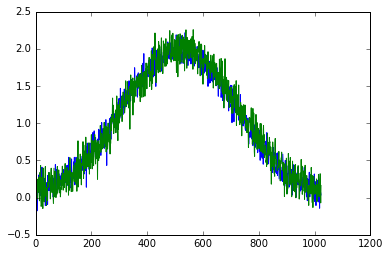

In [39]:
plt.plot(query)
plt.plot(tsdict[nearestwanted])


#### How much time did finding similar take?

In [40]:
%%timeit
r = w.find_similar(query)
results = json.loads(r.content.decode('utf-8'))
results

1 loop, best of 3: 1.18 s per loop


### Making a Vantage Point Tree

In [41]:
r = w.make_vp_tree()
r.content.decode('utf-8')

'"WriteSuccessful"'

#### How much time does finding similar take now?

In [42]:
%%timeit
r = w.find_similar(query)
results = json.loads(r.content.decode('utf-8'))
results

1 loop, best of 3: 514 ms per loop


### Deleting TimeSeries

In [43]:
r = w.delete_ts(nearestwanted)
r.content.decode('utf-8')

'"WriteSuccessful"'

Lets find the most similar again to make sure we got rid of it.

In [44]:
r = w.find_similar(query)
results = json.loads(r.content.decode('utf-8'))
results

{'ts-409': 0.0331546088899852}